This is the solution for the question 2 in Algorithm #2

In [17]:
# Import necessary libraries
import random
from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt


Code snippet below is meant to create two classes: Apprentice and PotionBusiness with no changes from the first question

In [3]:
# Remains unchanged from the first question
@dataclass
class Apprentice:
    id: int
    potions_made: int = 0
    speed_boost: float = 1.0
    
    def make_potions(self, spell: str = None) -> Tuple[int, float]:
        base_production = 1 * self.speed_boost
        price_boost = 0
        
        if spell == "Haste":
            base_production *= 1.18
        elif spell == "Empower":
            price_boost = 100
        elif spell == "Lady Luck":
            if random.random() < 0.12:  # 12% chance
                base_production *= 2
        
        potions = base_production
        self.potions_made += potions
        
        # Check for milestone bonus
        old_milestones = (self.potions_made - potions) // 10
        new_milestones = self.potions_made // 10
        if new_milestones > old_milestones:
            # self.speed_boost *= (1.07 ** (new_milestones - old_milestones))
            new_boost = self.speed_boost * (1.07 ** (new_milestones - old_milestones))
            self.speed_boost = min(new_boost, 10.0)
            
        return potions, 1000 + price_boost

class PotionBusiness:
    def __init__(self):
        self.apprentices = [Apprentice(i) for i in range(3)]
        self.total_revenue = 0
        self.total_costs = 0
        self.day = 0
        
    def simulate_day(self, spell_assignments: List[Tuple[int, str]] = None, weekend: bool = False) -> dict:
        self.day += 1
        daily_revenue = 0
        daily_production = 0
        
        if weekend:
            self.total_costs += 7000  # Weekend overtime cost
        
        spells = {app_id: spell for app_id, spell in (spell_assignments or [])}
        
        for app in self.apprentices:
            potions, price = app.make_potions(spells.get(app.id))
            revenue = potions * price
            daily_revenue += revenue
            daily_production += potions
        
        self.total_revenue += daily_revenue
        
        return {
            'day': self.day,
            'daily_production': daily_production,
            'daily_revenue': daily_revenue,
            'total_revenue': self.total_revenue,
            'total_costs': self.total_costs,
            'net_profit': self.total_revenue - self.total_costs
        }



Them important part was added here with 2 functions: run_simulation() and monte_carlo_analysis(). 
The function run_simulation has three options representing three built-in strategies: 
- optimal: we don't use the third spell 'Lady Luck' to exclude any risk), 
- lucky: we cast 2 'Lady Luck' on two apprentice every day, which represent a complete luck-based option
- mixed: we randomly assign each cast on 

In [ ]:
def run_simulation(days: int, strategy: str = "optimal") -> float:
    """
    Run a single simulation for specified number of days.
    Returns final net profit
    """
    business = PotionBusiness()
    
    for day in range(1, days + 1):
        is_weekend = (day % 7 in [6, 7])
        
        if strategy == "optimal":
            # Optimal strategy: Haste on best producer, Empower on second best
            spell_assignments = [
                (0, "Haste"),
                (1, "Empower")
            ]
        elif strategy == "lucky":
            # Lucky strategy: Try Lady Luck on two apprentices
            spell_assignments = [
                (0, "Lady Luck"),
                (1, "Lady Luck")
            ]
        elif strategy == "mixed":
            # Mixed strategy: Randomly assign spells
            spell_options = ["Haste", "Empower", "Lady Luck", None]
            chosen_apprentices = random.sample([0, 1, 2], 2)
            spell_assignments = [
                (chosen_apprentices[0], random.choice(spell_options)),
                (chosen_apprentices[1], random.choice(spell_options))
            ]
        
        business.simulate_day(spell_assignments, weekend=is_weekend)
    
    return business.total_revenue - business.total_costs

def monte_carlo_analysis(num_simulations: int = 10000, days: int = 100, target = 1000000) -> dict:
    """
    Run multiple simulations and analyze the distribution
    """
    results_optimal = []
    results_lucky = []
    results_mixed = []
    
    for _ in range(num_simulations):
        results_optimal.append(run_simulation(days, "optimal"))
        results_lucky.append(run_simulation(days, "lucky"))
        results_mixed.append(run_simulation(days, "mixed"))
    
    # Calculate probabilities of reaching target
    prob_optimal = sum(1 for x in results_optimal if x >= target) / num_simulations
    prob_lucky = sum(1 for x in results_lucky if x >= target) / num_simulations
    prob_mixed = sum(1 for x in results_mixed if x >= target) / num_simulations

    return {
        'optimal': results_optimal,
        'lucky': results_lucky,
        'mixed': results_mixed,
        'days': days,
        'num_simulations': num_simulations,
        'probabilities': {
            'optimal': prob_optimal,
            'lucky': prob_lucky,
            'mixed': prob_mixed
        }
    }

In [4]:
def find_days_to_target(target_amount: float = 1000000) -> int:
    left, right = 1, 1000  # Start with reasonable bounds
    
    while left < right:
        mid = (left + right) // 2
        # Run several simulations with 'optimal' strategy
        results = [run_simulation(mid, "optimal") for _ in range(100)]
        max_profit = max(results)  # Best case scenario
        
        if max_profit < target_amount:
            left = mid + 1
        else:
            right = mid
            
    return left

In [7]:
def visualize_monte_carlo_results(results):
    """
    Visualize the Monte Carlo simulation results with probability information
    """
    optimal_results = results['optimal']
    lucky_results = results['lucky']
    mixed_results = results['mixed']
    probs = results['probabilities']
    
    # Create a figure with three subplots
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0, 0])
    bp = ax1.boxplot([optimal_results, lucky_results, mixed_results], 
                    labels=['Optimal', 'Lucky', 'Mixed'])
    ax1.set_title('Net Profit Distribution')
    ax1.set_ylabel('Net Profit ($)')
    ax1.axhline(y=1000000, color='r', linestyle='--', label='$1M Target')
    ax1.legend()
    
    # Histogram
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.hist(optimal_results, bins=30, alpha=0.5, label=f'Optimal ({probs["optimal"]:.1%} chance)')
    ax2.hist(lucky_results, bins=30, alpha=0.5, label=f'Lucky ({probs["lucky"]:.1%} chance)')
    ax2.hist(mixed_results, bins=30, alpha=0.5, label=f'Mixed ({probs["mixed"]:.1%} chance)')
    ax2.axvline(x=1000000, color='r', linestyle='--', label='$1M Target')
    ax2.set_title('Net Profit Distribution')
    ax2.set_xlabel('Net Profit ($)')
    ax2.set_ylabel('Frequency')

    max_frequency = max(
        np.histogram(lucky_results, bins=30)[0].max(),
        np.histogram(mixed_results, bins=30)[0].max()
    )
    ax2.set_ylim(0, max_frequency * 1.1)  # Add 10% padding

    ax2.legend()
    
    # Probability bar chart
    ax3 = fig.add_subplot(gs[1, :])
    strategies = ['Optimal Strategy', 'Lucky Strategy', 'Mixed Strategy']
    probabilities = [probs['optimal'], probs['lucky'], probs['mixed']]
    bars = ax3.bar(strategies, probabilities)
    ax3.set_title('Probability of Reaching $1M Target')
    ax3.set_ylabel('Probability')
    
    # Add percentage labels on bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1%}',
                ha='center', va='bottom')
    
    # Add overall statistics in text box
    stats_text = (
        f"Monte Carlo Simulation Results\n"
        f"Number of simulations: {results['num_simulations']}\n"
        f"Days simulated: {results['days']}\n\n"
        f"Optimal Strategy:\n"
        f"  Mean: ${np.mean(optimal_results):,.0f}\n"
        f"  Median: ${np.median(optimal_results):,.0f}\n"
        f"  Std Dev: ${np.std(optimal_results):,.0f}\n\n"
        f"Lucky Strategy:\n"
        f"  Mean: ${np.mean(lucky_results):,.0f}\n"
        f"  Median: ${np.median(lucky_results):,.0f}\n"
        f"  Std Dev: ${np.std(lucky_results):,.0f}\n\n"
        f"Mixed Strategy:\n"
        f"  Mean: ${np.mean(mixed_results):,.0f}\n"
        f"  Median: ${np.median(mixed_results):,.0f}\n"
        f"  Std Dev: ${np.std(mixed_results):,.0f}"
    )
    plt.figtext(1.02, 0.5, stats_text, fontsize=10, family='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Print probability summary
    print("\nProbability of reaching $1M target:")
    print(f"Optimal Strategy: {probs['optimal']:.1%}")
    print(f"Lucky Strategy: {probs['lucky']:.1%}")
    print(f"Mixed Strategy: {probs['mixed']:.1%}")

/var/folders/q3/x_g82ynx00q7tn_jc9j82wk80000gn/T/ipykernel_782/1633214040.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot([optimal_results, lucky_results, mixed_results],


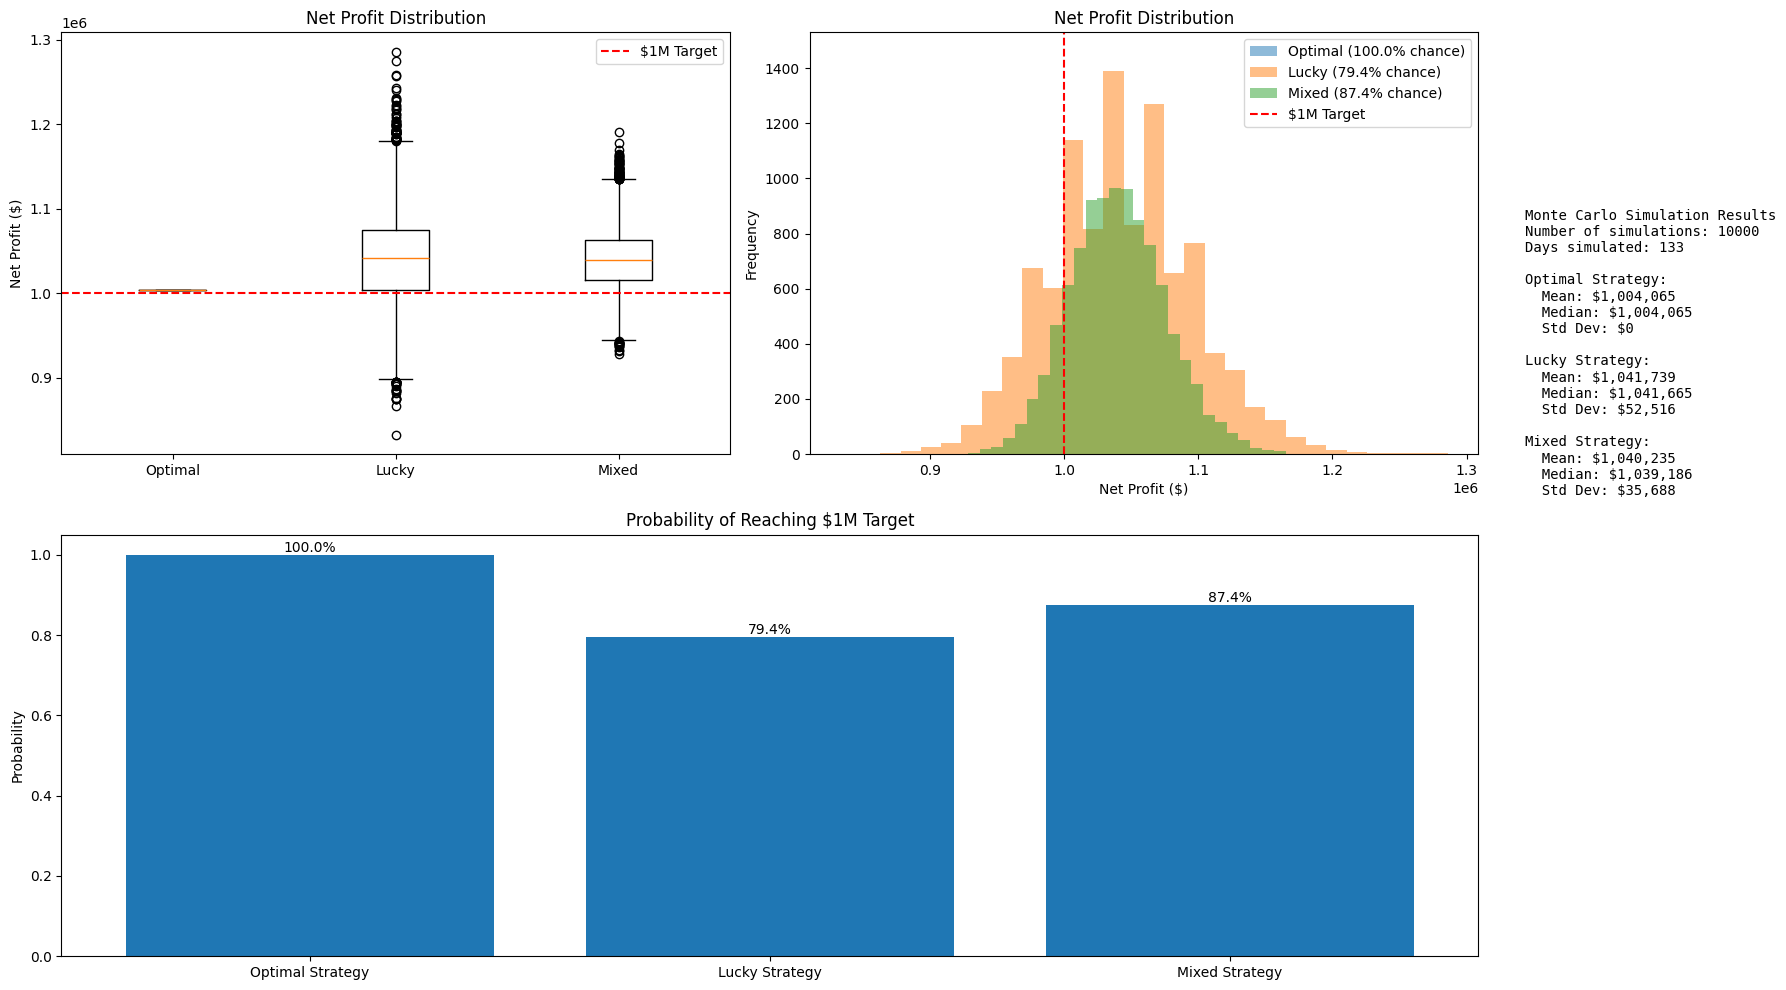


Probability of reaching $1M target:
Optimal Strategy: 100.0%
Lucky Strategy: 79.4%
Mixed Strategy: 87.4%


In [8]:
# Run the analysis and visualize
results = monte_carlo_analysis(days=find_days_to_target())
visualize_monte_carlo_results(results)

In [14]:
def analyze_probabilities_over_time(
    min_days: int = 30,
    max_days: int = 365,
    step: int = 15,
    num_simulations: int = 1000,
    target: float = 1000000
) -> dict:
    """
    Analyze probability of reaching target amount across different time periods
    using the existing monte_carlo_analysis function
    
    Args:
        min_days: Minimum number of days to simulate
        max_days: Maximum number of days to simulate
        step: Number of days between each time period
        num_simulations: Number of simulations per time period
        target: Target amount to reach (default $1M)
    """
    days_range = range(min_days, max_days + 1, step)
    probabilities = {
        'days': list(days_range),
        'optimal': [],
        'lucky': [],
        'mixed': []
    }
    
    for days in days_range:
        # print(f"Analyzing {days} days period...")
        
        # Use existing monte_carlo_analysis function
        results = monte_carlo_analysis(num_simulations=num_simulations, days=days, target=target)
        
        # Extract probabilities
        probabilities['optimal'].append(results['probabilities']['optimal'])
        probabilities['lucky'].append(results['probabilities']['lucky'])
        probabilities['mixed'].append(results['probabilities']['mixed'])
    
    return probabilities

def visualize_time_based_probabilities(probabilities: dict):
    """
    Create a line chart showing how probabilities change over time
    
    Args:
        probabilities: Dictionary containing days and probabilities for each strategy
    """
    plt.figure(figsize=(12, 7))
    
    # Plot lines for each strategy
    plt.plot(probabilities['days'], probabilities['optimal'], 
             marker='o', label='Optimal Strategy', linewidth=2, color='#2ecc71')
    plt.plot(probabilities['days'], probabilities['lucky'], 
             marker='s', label='Lucky Strategy', linewidth=2, color='#e74c3c')
    plt.plot(probabilities['days'], probabilities['mixed'], 
             marker='^', label='Mixed Strategy', linewidth=2, color='#3498db')
    
    # Customize the plot
    plt.title('Probability of Reaching $1M Over Time', fontsize=14, pad=20)
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Customize axis
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Add legend
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Add annotations for key points
    for strategy, color in zip(['optimal', 'lucky', 'mixed'], ['#2ecc71', '#e74c3c', '#3498db']):
        final_prob = probabilities[strategy][-1]
        plt.annotate(
            f'{final_prob:.1%}',
            xy=(probabilities['days'][-1], final_prob),
            xytext=(10, 0),
            textcoords='offset points',
            ha='left',
            va='center',
            color=color
        )
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Print numerical results
    # print("\nProbabilities at different time periods:")
    # print("\nDays | Optimal | Lucky | Mixed")
    # print("-" * 40)
    # for i, days in enumerate(probabilities['days']):
    #     print(f"{days:4d} | {probabilities['optimal'][i]:7.1%} | {probabilities['lucky'][i]:5.1%} | {probabilities['mixed'][i]:5.1%}")


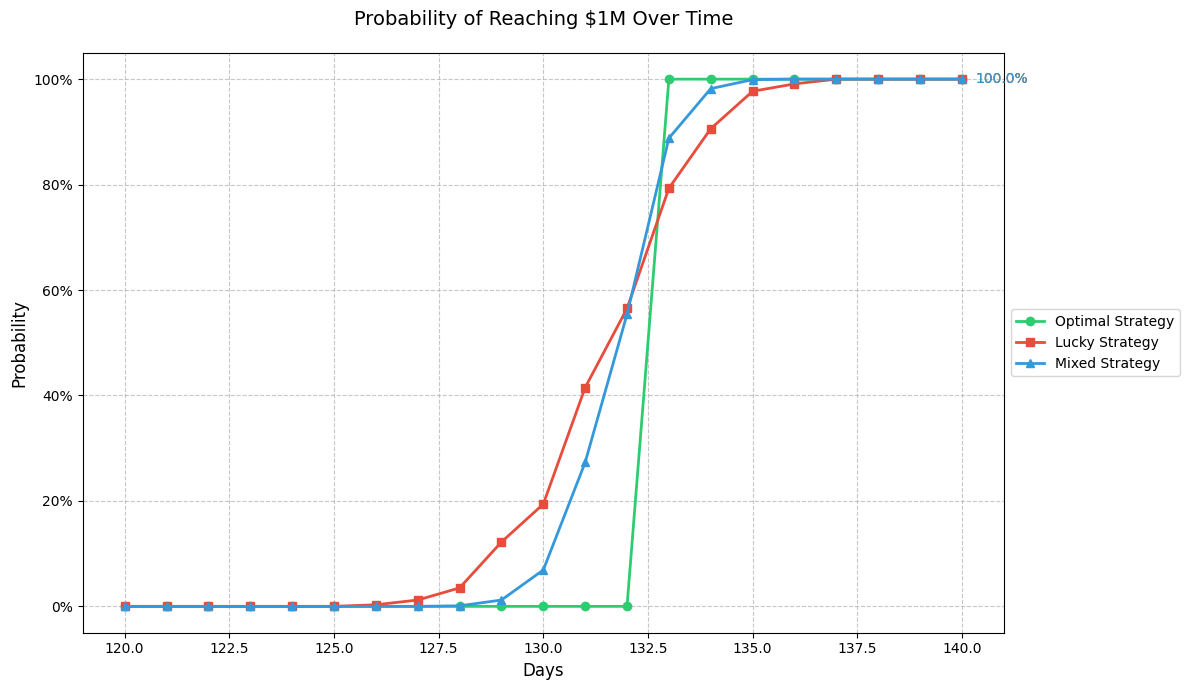

In [16]:
# Run the analysis
results = analyze_probabilities_over_time(
    min_days=120,
    max_days=140,
    step=1,
    num_simulations=1000  # Reduced for faster computation, increase for more accuracy
)

# Visualize the results
visualize_time_based_probabilities(results)